In [33]:
import torchvision
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import glob
import matplotlib.pyplot as plt
from glob import glob
import torchvision.transforms as transforms

Reference: https://www.kaggle.com/code/ggsri123/implementing-resnet18-for-image-classification
Note this is binary classification, we edited the model to make it multi-classification.

In [4]:
def get_model(num_classes):
    model = models.resnet18(pretrained=True)
    
    # Freeze the parameters of the model
    for param in model.parameters():
        param.requires_grad = False
    
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, num_classes)
    )

    loss_fn = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

    return model.to(device), loss_fn, optimizer


In [3]:
!pip install torch_summary
from torchsummary import summary
model, criterion, optimizer = get_model()
summary(model, torch.zeros(1,3,224,224))

/Users/laurie/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/laurie/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/laurie/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 29.8MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

In [21]:
def train_batch(x, y, model, optimizer, loss_fn):
    model.train()  # Set the model to training mode
    prediction = model(x)
    
    # For multi-class classification, ensure y is in the correct shape
    # and of a suitable dtype, like long. 
    # This might require modification depending on how your labels 'y' are provided.

    batch_loss = loss_fn(prediction, y)  # CrossEntropyLoss is used for multi-class
    
    optimizer.zero_grad()  # Zero the gradients before backward pass
    batch_loss.backward()  # Compute the gradients
    optimizer.step()  # Update parameters
    
    return batch_loss.item()


In [36]:
def accuracy(x, y, model):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        predictions = model(x)
        predicted_classes = torch.argmax(predictions, dim=1)
        correct_count = (predicted_classes == y).sum().item()
        total_count = y.size(0)
        return correct_count / total_count

In [25]:
from custom_utils import get_annotations
from custom_utils import get_data
annotations = get_annotations()
trn_dl = get_data("extractedLabeledDataset", annotations)
model, loss_fn, optimizer = get_model(6)

/Users/laurie/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/laurie/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [37]:
train_losses, train_accuracies = [], []

print("All losses and accuracies are for each epoch")
for epoch in range(5):
    train_epoch_losses, train_epoch_accuracies = [], []

    for ix, batch in enumerate(iter(trn_dl)):
        try:
            x, y = batch
            x = x.float()  # Convert to float
            y = y.long()   # Convert to long for classification labels

            batch_loss = train_batch(x, y, model, optimizer, loss_fn)
            train_epoch_losses.append(batch_loss)
        except Exception as e:
            print(f"An error occurred at batch {ix}: {e}")
            continue  # Skip this batch

    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        x = x.float()  # Convert to float
        y = y.long()   # Convert to long for classification labels
        

        batch_accuracy = accuracy(x, y, model)
        train_epoch_accuracies.append(batch_accuracy)

    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    print(f"Epoch {epoch + 1}/5, Training Loss: {train_epoch_loss:.4f}, Training Accuracy: {train_epoch_accuracy:.4f}")
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)

All losses and accuracies are for each epoch
Epoch 1/5, Training Loss: 1.4078, Training Accuracy: 0.3738
Epoch 2/5, Training Loss: 1.3825, Training Accuracy: 0.3943
Epoch 3/5, Training Loss: 1.3674, Training Accuracy: 0.3920
Epoch 4/5, Training Loss: 1.3467, Training Accuracy: 0.4011
Epoch 5/5, Training Loss: 1.3255, Training Accuracy: 0.3919


<ipython-input-39-013a8807a396>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


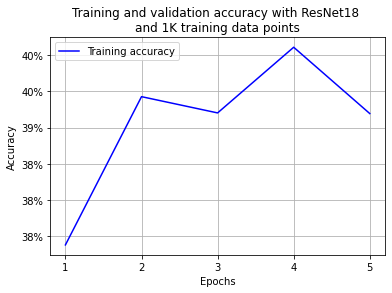

In [39]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
# plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with ResNet18 \nand 1K training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()